In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Thu Jan 25 19:08:42 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   36C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 4
-rw-rw-r-- 1 scpark scpark 40  1월 25 19:08 events.out.tfevents.1706177315.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

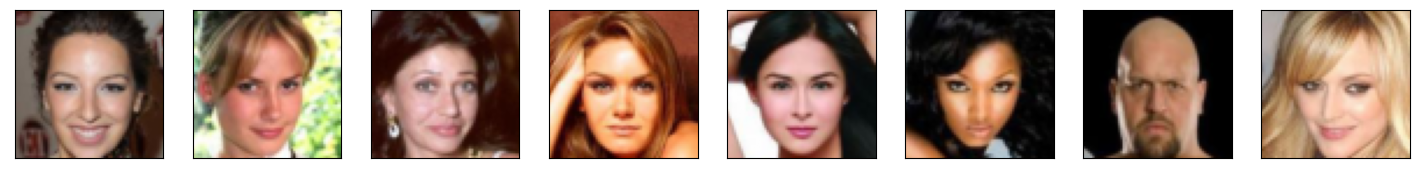

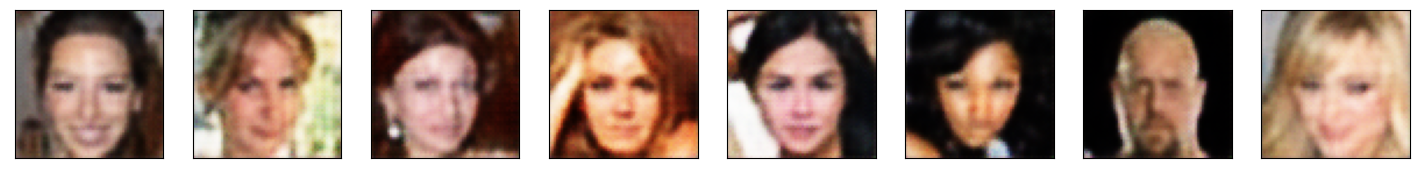

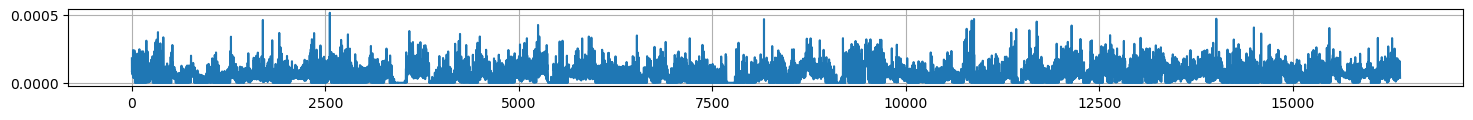

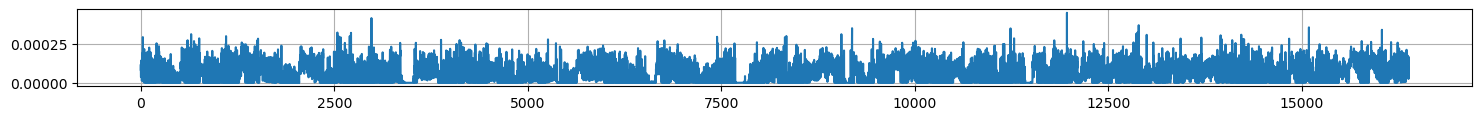

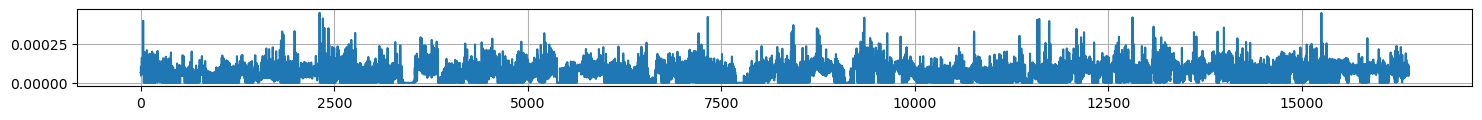

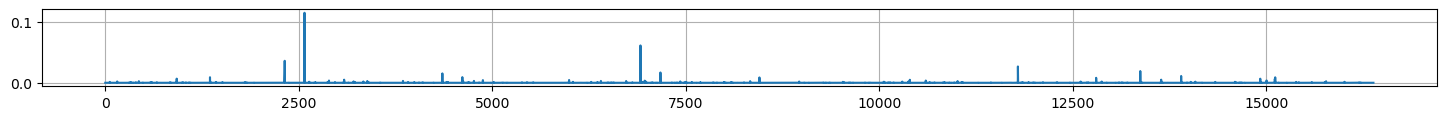

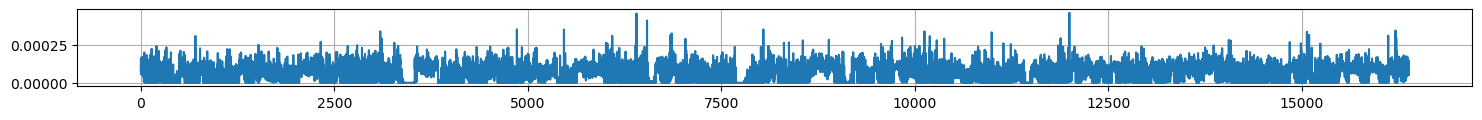

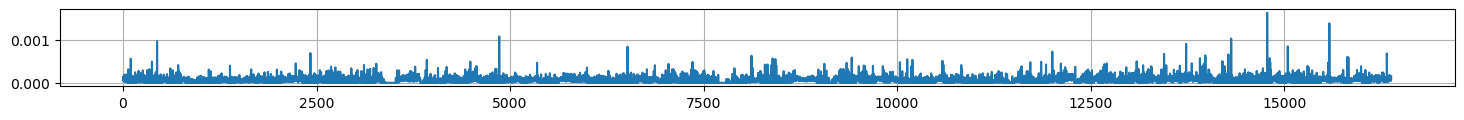

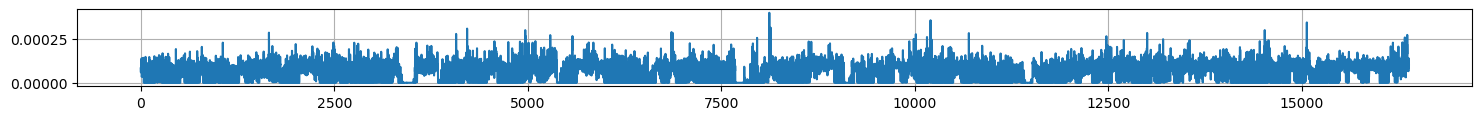

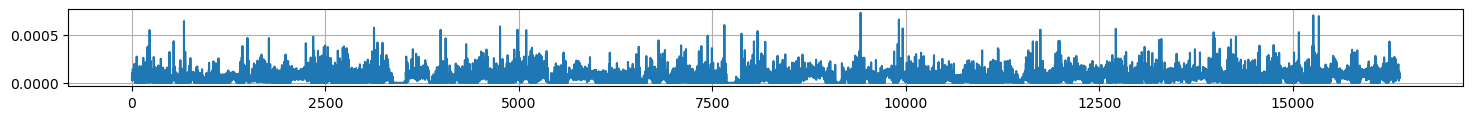

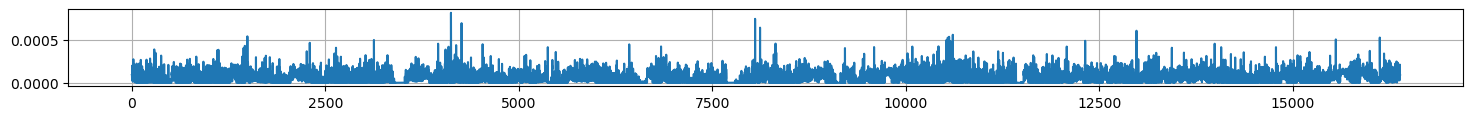

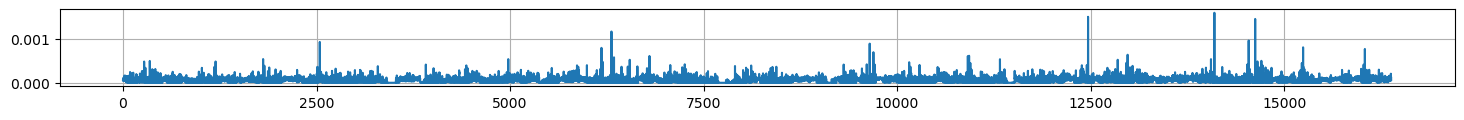

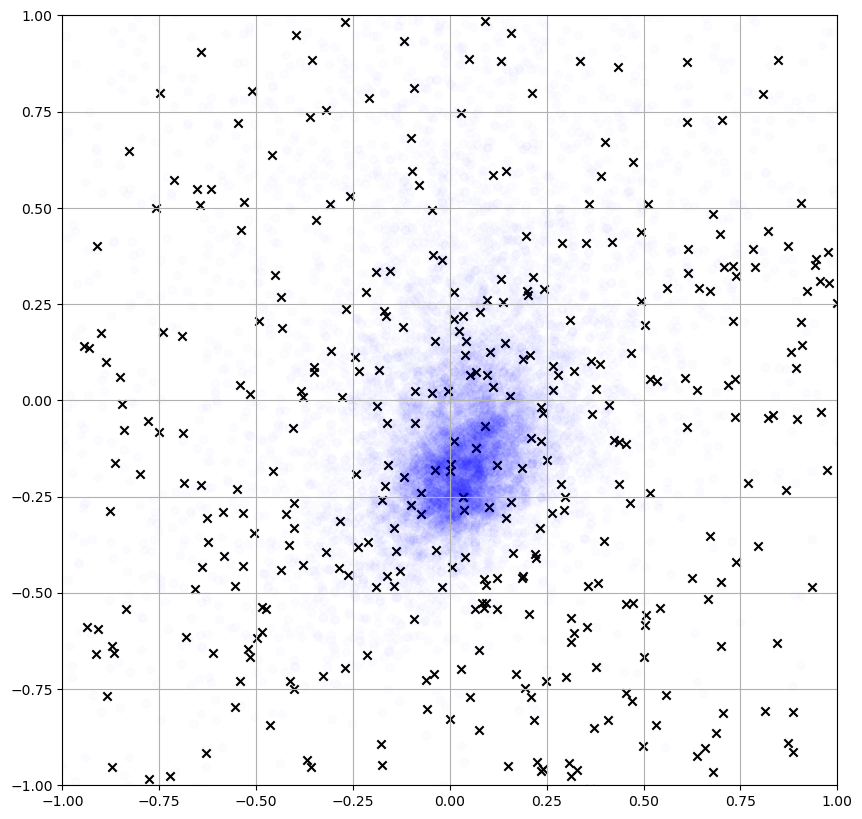

2001
lse_loss -31.030635833740234
commit_loss 0.029338259249925613
recon_loss 0.002510290127247572
2002
lse_loss -31.05398178100586
commit_loss 0.027490505948662758
recon_loss 0.0024546068161726
2003
lse_loss -31.0589599609375
commit_loss 0.027289483696222305
recon_loss 0.0026032428722828627
2004
lse_loss -31.04520034790039
commit_loss 0.029933195561170578
recon_loss 0.0027578743174672127
2005
lse_loss -31.07634735107422
commit_loss 0.026554077863693237
recon_loss 0.0028116514440625906
2006
lse_loss -31.094676971435547
commit_loss 0.0254768468439579
recon_loss 0.0025838331785053015
2007
lse_loss -31.034618377685547
commit_loss 0.030754702165722847
recon_loss 0.0027422597631812096
2008
lse_loss -31.081809997558594
commit_loss 0.026385856792330742
recon_loss 0.0027782442048192024
2009
lse_loss -31.12444305419922
commit_loss 0.02486259490251541
recon_loss 0.0022418031003326178
2010
lse_loss -31.088111877441406
commit_loss 0.027175160124897957
recon_loss 0.0025667999871075153
2011
lse_loss

2085
lse_loss -31.344444274902344
commit_loss 0.02798435091972351
recon_loss 0.0026042337995022535
2086
lse_loss -31.33599853515625
commit_loss 0.029985427856445312
recon_loss 0.00271567958407104
2087
lse_loss -31.35360336303711
commit_loss 0.02845587208867073
recon_loss 0.0024229325354099274
2088
lse_loss -31.394676208496094
commit_loss 0.028320565819740295
recon_loss 0.002611425705254078
2089
lse_loss -31.386829376220703
commit_loss 0.026230409741401672
recon_loss 0.0025261477567255497
2090
lse_loss -31.388263702392578
commit_loss 0.026728661730885506
recon_loss 0.0026086855214089155
2091
lse_loss -31.392925262451172
commit_loss 0.026118751615285873
recon_loss 0.002535419538617134
2092
lse_loss -31.41421127319336
commit_loss 0.024797655642032623
recon_loss 0.0027306429110467434
2093
lse_loss -31.421993255615234
commit_loss 0.026268670335412025
recon_loss 0.002311925869435072
2094
lse_loss -31.404006958007812
commit_loss 0.02707783132791519
recon_loss 0.0025365452747792006
2095
lse_lo

2170
lse_loss -31.66412353515625
commit_loss 0.027842164039611816
recon_loss 0.002665107138454914
2171
lse_loss -31.696834564208984
commit_loss 0.025948230177164078
recon_loss 0.0024737652856856585
2172
lse_loss -31.722923278808594
commit_loss 0.02361040748655796
recon_loss 0.002534694503992796
2173
lse_loss -31.704830169677734
commit_loss 0.026037361472845078
recon_loss 0.0024788188748061657
2174
lse_loss -31.69019317626953
commit_loss 0.02887718193233013
recon_loss 0.002467923564836383
2175
lse_loss -31.70499038696289
commit_loss 0.02575516514480114
recon_loss 0.002734014531597495
2176
lse_loss -31.74331283569336
commit_loss 0.023618360981345177
recon_loss 0.0023783789947628975
2177
lse_loss -31.71306610107422
commit_loss 0.025084631517529488
recon_loss 0.0023483410477638245
2178
lse_loss -31.676815032958984
commit_loss 0.027782734483480453
recon_loss 0.002520036417990923
2179
lse_loss -31.716846466064453
commit_loss 0.025896042585372925
recon_loss 0.0028876042924821377
2180
lse_loss

lse_loss -32.038795471191406
commit_loss 0.021967750042676926
recon_loss 0.002281992696225643
2255
lse_loss -32.003021240234375
commit_loss 0.024710945785045624
recon_loss 0.0025620346423238516
2256
lse_loss -31.998424530029297
commit_loss 0.02458583191037178
recon_loss 0.003750832751393318
2257
lse_loss -32.028987884521484
commit_loss 0.023707468062639236
recon_loss 0.00221374724060297
2258
lse_loss -31.99506378173828
commit_loss 0.025571396574378014
recon_loss 0.002280574757605791
2259
lse_loss -31.983604431152344
commit_loss 0.02877267822623253
recon_loss 0.0025545896496623755
2260
lse_loss -32.06527328491211
commit_loss 0.021319124847650528
recon_loss 0.002162298886105418
2261
lse_loss -32.02657699584961
commit_loss 0.02548670396208763
recon_loss 0.0024975682608783245
2262
lse_loss -31.982128143310547
commit_loss 0.02899504080414772
recon_loss 0.002409755950793624
2263
lse_loss -32.02383041381836
commit_loss 0.02495122328400612
recon_loss 0.002376454882323742
2264
lse_loss -32.0266

lse_loss -32.35036087036133
commit_loss 0.02152019925415516
recon_loss 0.0022148853167891502
2340
lse_loss -32.301029205322266
commit_loss 0.024660808965563774
recon_loss 0.002304395195096731
2341
lse_loss -32.262840270996094
commit_loss 0.027622126042842865
recon_loss 0.0029293743427842855
2342
lse_loss -32.32146072387695
commit_loss 0.024358568713068962
recon_loss 0.0024206885136663914
2343
lse_loss -32.331356048583984
commit_loss 0.023383023217320442
recon_loss 0.002441397635266185
2344
lse_loss -32.31714630126953
commit_loss 0.025261657312512398
recon_loss 0.002489746082574129
2345
lse_loss -32.32454299926758
commit_loss 0.024772828444838524
recon_loss 0.002226021606475115
2346
lse_loss -32.33634948730469
commit_loss 0.022966962307691574
recon_loss 0.0024283339735120535
2347
lse_loss -32.34352111816406
commit_loss 0.023078739643096924
recon_loss 0.002263265196233988
2348
lse_loss -32.361328125
commit_loss 0.02250879444181919
recon_loss 0.0022934582084417343
2349
lse_loss -32.359897

2423
lse_loss -32.617671966552734
commit_loss 0.02427051216363907
recon_loss 0.002495278138667345
2424
lse_loss -32.58523941040039
commit_loss 0.026291683316230774
recon_loss 0.002477116882801056
2425
lse_loss -32.620208740234375
commit_loss 0.02311098389327526
recon_loss 0.002497549168765545
2426
lse_loss -32.61371612548828
commit_loss 0.02405313029885292
recon_loss 0.00261960132047534
2427
lse_loss -32.62888717651367
commit_loss 0.02407246083021164
recon_loss 0.002335907658562064
2428
lse_loss -32.66893768310547
commit_loss 0.021686825901269913
recon_loss 0.002194085856899619
2429
lse_loss -32.654293060302734
commit_loss 0.022536596283316612
recon_loss 0.0023885020054876804
2430
lse_loss -32.626277923583984
commit_loss 0.025883948430418968
recon_loss 0.0026380768977105618
2431
lse_loss -32.660621643066406
commit_loss 0.022548742592334747
recon_loss 0.002194565488025546
2432
lse_loss -32.63968276977539
commit_loss 0.023272469639778137
recon_loss 0.0023967965971678495
2433
lse_loss -32

lse_loss -32.89769744873047
commit_loss 0.02422637678682804
recon_loss 0.002778562717139721
2508
lse_loss -32.95170974731445
commit_loss 0.021877769380807877
recon_loss 0.002479001646861434
2509
lse_loss -32.949214935302734
commit_loss 0.020773358643054962
recon_loss 0.002155904658138752
2510
lse_loss -32.97696304321289
commit_loss 0.019680071622133255
recon_loss 0.0020168002229183912
2511
lse_loss -32.93064498901367
commit_loss 0.022963285446166992
recon_loss 0.0021177837625145912
2512
lse_loss -32.96144104003906
commit_loss 0.022002043202519417
recon_loss 0.0022895769216120243
2513
lse_loss -32.951316833496094
commit_loss 0.022127849981188774
recon_loss 0.002342039719223976
2514
lse_loss -32.977027893066406
commit_loss 0.02103174477815628
recon_loss 0.002183836419135332


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-3
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()
plt.show() 